<a href="https://colab.research.google.com/github/Gamebred94/Machine-Learning/blob/master/Meanshift_clustering_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some synthetic data and show them in action.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [ ]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

Multiplying by 70 and subtracting by 35 results in centroids being randomly placed within a square region defined by x and y coordinates ranging from -35 to 35.

In [ ]:
centroids = torch.rand(n_clusters, 2)*70-35

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

Generating a sample space for each centroid with the centroid as mean and a std dev of 5(cov matrix) from a normal distribution

In the context of a multivariate normal distribution, the covariance matrix describes the relationships
- The values on the main diagonal of the matrix represent the variance of each dimension. A higher variance means the data is more spread out along that dimension.
- The values off the main diagonal represent the covariance between pairs of dimensions. A non-zero covariance indicates that the dimensions are correlated (e.g., as x increases, y also tends to increase).

Why do we do it?  
Independence: By setting the off-diagonal elements to zero, we are specifying that the x and y dimensions are independent. This means that the value of a data point's x-coordinate doesn't influence its y-coordinate, and vice versa. This is a common assumption for simplicity in generating synthetic data for clustering, resulting in clusters that are roughly spherical.  
Control over Spread: The values on the diagonal (5.0 in this case) control the spread or dispersion of the data points around the centroids along each dimension. A larger value would result in more scattered data points, while a smaller value would create tighter clusters.



In [ ]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
  if ax is None:
    _,ax = plt.subplots()
  for i,centroid in enumerate(centroids):
      samples = data[i*n_samples:(i+1)*n_samples]
      ax.scatter(samples[:,0], samples[:,1], s=1)
      ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5) # big-marker X
      ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2) # small-marker x


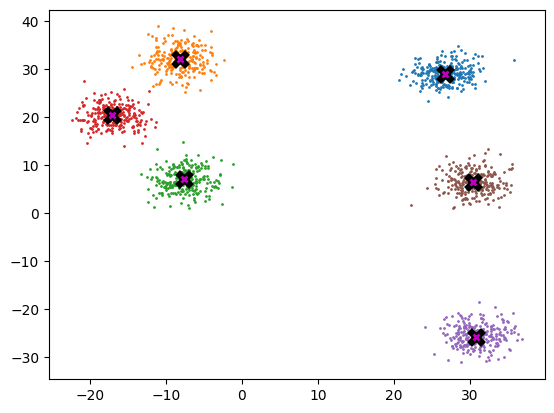

In [ ]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [ ]:
midp = centroids.mean(0)
midp

tensor([ 9.188, 11.615])

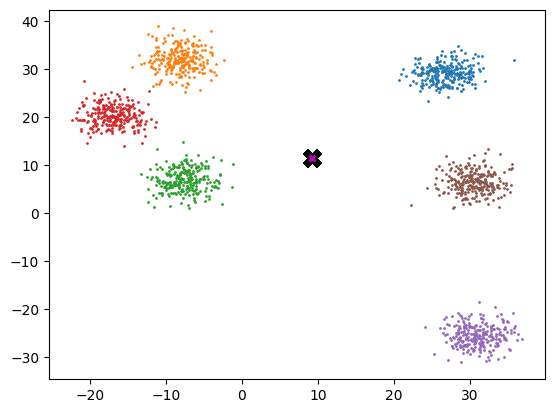

In [ ]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [ ]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi)) # where d is the distance and bw is the std. dev

In [ ]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

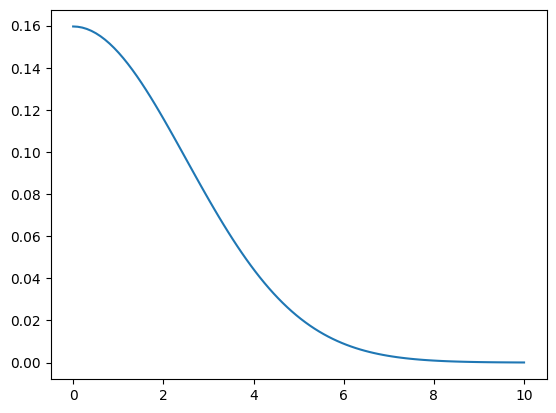

In [ ]:
plot_func(partial(gaussian, bw=2.5))

In [ ]:
f = partial(gaussian, bw=2.5)
f(tensor(4.))

tensor(0.044)

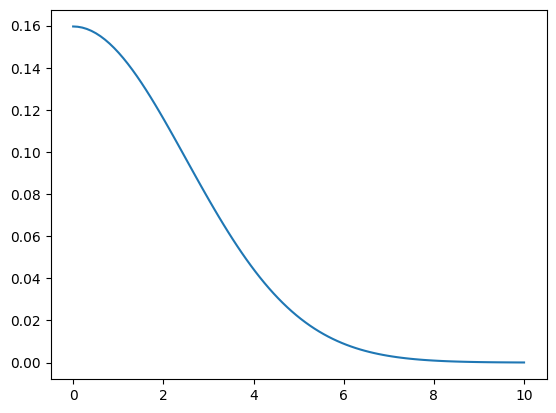

In [ ]:
#another approach
plot_func(lambda x: gaussian(x, bw=2.5))

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [ ]:
def tri(d,i):
  return (-d+i).clamp_min(0)/i

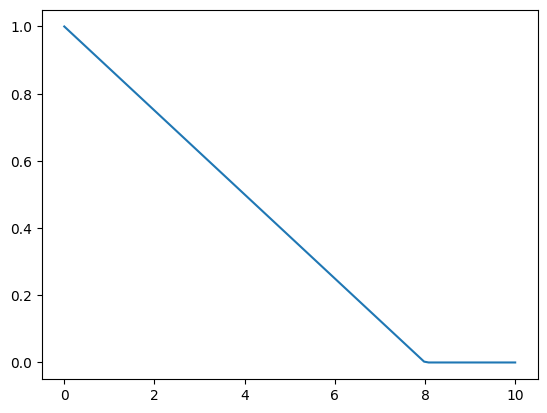

In [ ]:
plot_func(partial(tri, i=8))

In [ ]:
X = data.clone()
x = data[0]
x

tensor([26.204, 26.349])

In [ ]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [ ]:
(x[None] - X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [ ]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

Step 1:
For each data point x in the sample X, find the distance between that point x and every other point in X

In [ ]:
from fastcore.test import test_close,test_eq
dist = ((x-X)**2).sum(1).sqrt()
dist_ein = torch.sqrt(torch.einsum('ij,ij->i', (x-X), (x-X))) # same written using einsum
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [ ]:
test_close(dist, dist_ein)

Step 2: Create weights using the **Gaussian kernel** and the computed distance from Step 1

In [ ]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

Step3: Update x as the weighted average of all other points in X, weighted based on the previous step

In [ ]:
weight.shape, X.shape, weight[:,None].shape

(torch.Size([1500]), torch.Size([1500, 2]), torch.Size([1500, 1]))

In [ ]:
(weight[:,None]*X)

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [ ]:
def one_update(X):
  for i, x in enumerate(X):
    dist = torch.sqrt(((x-X)**2).sum(1))
    weight = gaussian(dist, 2.5)
    #weight = tri(dist, i=8) - can be used instead of gaussian
    X[i] = (weight[:,None]*X).sum(0)/weight.sum()


In [ ]:
def meanshift(data, iterations=5):
  X = data.clone()
  for it in range(iterations):
    one_update(X)
  return X

In [ ]:
%time X = meanshift(data)

CPU times: user 1.23 s, sys: 316 µs, total: 1.23 s
Wall time: 1.24 s


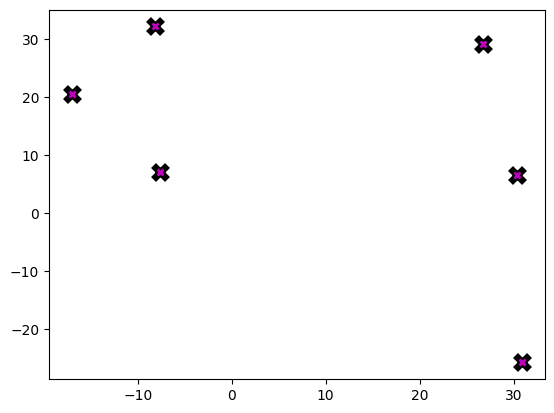

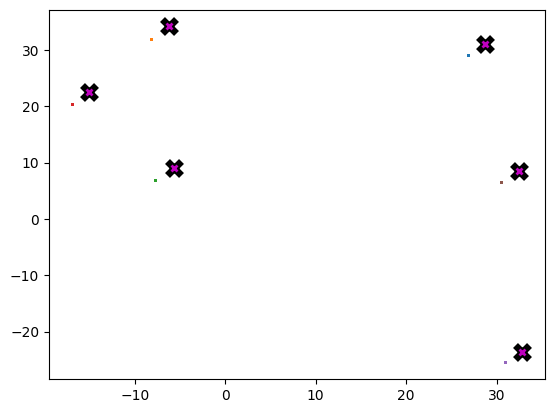

In [ ]:
plot_data(centroids, X, n_samples)
plot_data(centroids+2, X, n_samples) # centroids shifted to show the actual data pts

## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d): #d = frame
  if d: one_update(X)
  ax.clear()
  plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=800, repeat=False)
plt.close()
HTML(ani.to_jshtml())



## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [ ]:
bs = 5
X = data.clone()
x = X[:5]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [ ]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [ ]:
def dist_b(a,b): return (((a[None] - b[:,None])**2).sum(2)).sqrt()

In [ ]:
dist_b(X,x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [ ]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [ ]:
weight = gaussian(dist_b(X,x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [ ]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [ ]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [ ]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [ ]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [ ]:
torch.einsum("ij,jk->ik ", weight, X) # recreating the same operation using einsum

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [ ]:
weight@X #using matrix multi instead - The numerator of weighted sum is the same as matrix multiplication

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [ ]:
div = weight.sum(1, keepdim=True)
div.shape, num.shape

(torch.Size([5, 1]), torch.Size([5, 2]))

In [ ]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [ ]:
def meanshift(data, bs=500):
  n = len(data)
  X = data.clone()
  for it in range(5): #no of iterations for clustering
    for i in range(0, n, bs):
      s = slice(i, min(i+bs,n))
      weight = gaussian(dist_b(X, X[s]), 2.5)
      # weight = tri(dist_b(X, X[s]), 8)
      div = weight.sum(1, keepdim=True)
      X[s] = (weight@X)/div

  return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [ ]:
data = data.cuda()
data[:5]

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        [25.647, 30.033],
        [31.236, 30.093]], device='cuda:0')

In [ ]:
X = meanshift(data).cpu() # converged X after weight update
X[:5]

tensor([[26.758, 29.152],
        [26.758, 29.152],
        [26.758, 29.152],
        [26.758, 29.152],
        [26.758, 29.152]])

In [ ]:
%timeit -n 5 _= meanshift(data).cpu()

5.98 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n 5 _=meanshift(data, 1024).cpu()

4.88 ms ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


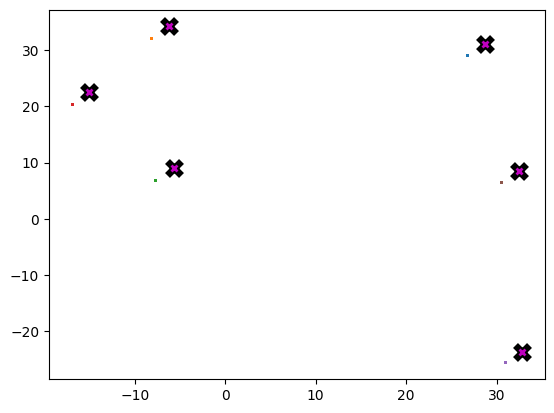

In [ ]:
plot_data(centroids+2, X, n_samples)

The formula for the Gaussian probability density function (PDF) for a single variable $x$ is:

$$ f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} $$

Where:
- $x$ is the variable
- $\mu$ is the mean
- $\sigma^2$ is the variance
- $\sigma$ is the standard deviation
- $e$ is the base of the natural logarithm (approximately 2.71828)
- $\pi$ is approximately 3.14159